### Notebook for the label transfer of Healthy-CTRL to rest of samples and conditions with `scANVI`

- **Developed by:** Carlos Talavera-López Ph.D
- **Modified by:** Mairi McClean
- **Institute of Computational Biology - Computational Health Department - Helmholtz Munich**
- original: v230504; modified v2305012


### Import required modules

In [1]:
import torch
import scvi
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker

Global seed set to 0
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/mairi.mcclean/mambaforge/envs/label_transfer_scvi/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.9.1
scanpy      1.9.3
-----
CoreFoundation      NA
Foundation          NA
PIL                 9.4.0
PyObjCTools         NA
absl                NA
anyio               NA
appnope             0.1.3
asttokens           NA
attr                22.2.0
babel               2.12.1
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
brotli              NA
certifi             2022.12.07
cffi                1.15.1
charset_normalizer  3.1.0
chex                0.1.7
colorama            0.4.6
comm                0.1.3
contextlib2         NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
defusedxml          0.7.1
docrep              0.3.2
executing           1.2.0
fastjsonschema      NA
flax                0.6.1
fsspec              2023.4.0
gmpy2               2.1.2
h5py                3.8.0
hypergeom_ufunc     NA
idna                3.4
igraph              0.10.4
importlib_resource

In [3]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'
torch.set_float32_matmul_precision('medium')

Global seed set to 1712


In [4]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 3,
)

### Read in Healthy data

In [6]:
adata_reference = sc.read_h5ad('../data/meyer_nikolic_covid_pbmc_raw.h5ad')
adata_reference

AnnData object with n_obs × n_vars = 422220 × 33559
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'Smoker', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'patient_id', 'sample_id', 'sequencing_library', 'Protein_modality_weight'
    var: 'name'

- Subset for healthy controls

In [7]:
healthy_ctrl = adata_reference[adata_reference.obs['COVID_status'].isin(['Healthy'])]
healthy_ctrl.obs['COVID_status'].value_counts()

COVID_status
Healthy    173684
Name: count, dtype: int64

### Reference.obs formatting
- First level of label transfer will be performed with 'broad' category

In [8]:
healthy_ctrl.obs.rename(columns={"patient_id": "donor"}, inplace=True)
healthy_ctrl.obs.rename(columns={"COVID_status": "status"}, inplace=True)
healthy_ctrl.obs.rename(columns={"Sex": "gender"}, inplace=True)
healthy_ctrl.obs.rename(columns={"Age_group": "age"}, inplace=True)
healthy_ctrl.obs['tissue'] = 'PBMC'
healthy_ctrl.obs

orig.ident   
index                                                                                   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...  CV001_KM10202384-CV001_KM10202394  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...  CV001_KM10202384-CV001_KM10202394   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...  CV001_KM10202384-CV001_KM10202394   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...  CV001_KM10202384-CV001_KM10202394   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...  CV001_KM10202384-CV001_KM10202394   
...                                                                               ...   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTCGCATCG-1    CV001_KM9166642-CV001_KM9166650   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTGTAAGTA-1    CV001_KM9166642-CV001_KM9166650   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCATGTCCC-1    CV001_KM9166642-CV001_KM9166650   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCGAGGTAG-1    CV001_KM9166642-CV001_KM9166650   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCTGCTGCT-1    CV001_KM9166642-CV001_KM9166650   

                                                    nCount_RNA  nFeature_RNA   
index                                                                          
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...      5493.0          1767  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...      4868.0          1577   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...      3178.0          1257   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...      4745.0          1477   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...      1902.0           954   
...                                                        ...           ...   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTCGCATCG-1      3513.0          1297   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTGTAAGTA-1      1888.0          1296   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCATGTCCC-1      1798.0           814   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCGAGGTAG-1      4407.0          1351   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCTGCTGCT-1      2676.0          1297   

                                                    nCount_ADT  nFeature_ADT   
index                                                                          
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...      5297.0           184  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...      2169.0           165   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...      1330.0           163   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...      1255.0           161   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...      1711.0           166   
...                                                        ...           ...   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTCGCATCG-1       513.0           137   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTGTAAGTA-1       631.0           145   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCATGTCCC-1      2227.0           169   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCGAGGTAG-1      1014.0           153   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCTGCTGCT-1       779.0           138   

                                                           age      BMI   
index                                                                     
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...       Adult  Unknown  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...       Adult  Unknown   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...       Adult  Unknown   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...       Adult  Unknown   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...       Adult  Unknown   
...                                                        ...      ...   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTCGCATCG-1  Adolescent     24.7   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTGTAAGTA-1  Adolescent     24.7   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCATGTCCC-1       Child     18.2   
CV001_KM91

In [9]:
healthy_ctrl.obs['seed_labels'] = healthy_ctrl.obs['annotation_broad'].copy()
del(healthy_ctrl.obs['annotation_broad'])
healthy_ctrl

AnnData object with n_obs × n_vars = 173684 × 33559
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'age', 'BMI', 'COVID_severity', 'status', 'Ethnicity', 'Group', 'gender', 'Smoker', 'annotation_detailed', 'annotation_detailed_fullNames', 'donor', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'tissue', 'seed_labels'
    var: 'name'

In [10]:
healthy_ctrl.obs['seed_labels'].value_counts()

seed_labels
T CD4+       49415
T CD8+       34110
Monocyte     28637
B            26132
NK           21871
T reg         3251
T g/d         3183
MAIT          2213
DC            2151
Cycling       1012
Platelets      626
HPC            416
Plasma         352
ILC            199
RBC            106
Baso/Eos        10
Name: count, dtype: int64

### Read in query dataset and subset

In [11]:
query = sc.read_h5ad('../data/Cai2020_scRNA_PBMC_mm230315_qcd.h5ad')
query.obs['seed_labels'] = 'Unknown'
query

AnnData object with n_obs × n_vars = 73146 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'seed_labels'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'donor_colors'
    layers: 'counts', 'sqrt_norm'

In [12]:
query.obs['status'].value_counts()

status
active_TB    33104
Healthy      22049
latent_TB    17993
Name: count, dtype: int64

In [14]:
query_healthy = query[query.obs['status'].isin(['Healthy'])]


### Concatenate data

In [15]:
adata = healthy_ctrl.concatenate(query_healthy, batch_key = 'dataset', batch_categories = ['reference', 'query'], join = 'inner')
adata

AnnData object with n_obs × n_vars = 195733 × 22792
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'age', 'BMI', 'COVID_severity', 'status', 'Ethnicity', 'Group', 'gender', 'Smoker', 'annotation_detailed', 'annotation_detailed_fullNames', 'donor', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'tissue', 'seed_labels', 'study', 'individual', 'sample', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'dataset'
    var: 'gene_id-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'name-reference'

In [16]:
adata.obs

orig.ident   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...  CV001_KM10202384-CV001_KM10202394  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...  CV001_KM10202384-CV001_KM10202394   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...  CV001_KM10202384-CV001_KM10202394   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...  CV001_KM10202384-CV001_KM10202394   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...  CV001_KM10202384-CV001_KM10202394   
...                                                                               ...   
TTTGTCAGTCGCGGTT-H1-query                                                         NaN   
TTTGTCAGTCGCTTCT-H1-query                                                         NaN   
TTTGTCAGTTCGAATC-H1-query                                                         NaN   
TTTGTCAGTTTGGGCC-H1-query                                                         NaN   
TTTGTCATCCCATTAT-H1-query                                                         NaN   

                                                    nCount_RNA  nFeature_RNA   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...      5493.0        1767.0  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...      4868.0        1577.0   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...      3178.0        1257.0   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...      4745.0        1477.0   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...      1902.0         954.0   
...                                                        ...           ...   
TTTGTCAGTCGCGGTT-H1-query                                  NaN           NaN   
TTTGTCAGTCGCTTCT-H1-query                                  NaN           NaN   
TTTGTCAGTTCGAATC-H1-query                                  NaN           NaN   
TTTGTCAGTTTGGGCC-H1-query                                  NaN           NaN   
TTTGTCATCCCATTAT-H1-query                                  NaN           NaN   

                                                    nCount_ADT  nFeature_ADT   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...      5297.0         184.0  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...      2169.0         165.0   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...      1330.0         163.0   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...      1255.0         161.0   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...      1711.0         166.0   
...                                                        ...           ...   
TTTGTCAGTCGCGGTT-H1-query                                  NaN           NaN   
TTTGTCAGTCGCTTCT-H1-query                                  NaN           NaN   
TTTGTCAGTTCGAATC-H1-query                                  NaN           NaN   
TTTGTCAGTTTGGGCC-H1-query                                  NaN           NaN   
TTTGTCATCCCATTAT-H1-query                                  NaN           NaN   

                                                      age      BMI   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...  Adult  Unknown  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...  Adult  Unknown   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...  Adult  Unknown   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...  Adult  Unknown   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...  Adult  Unknown   
...                                                   ...      ...   
TTTGTCAGTCGCGGTT-H1-query                              26      NaN   
TTTGTCAGTCGCTTCT-H1-query                              26      NaN   
TTTGTCAGTTCGAATC-H1-query                              26      NaN   
TTTGTCAGTTTGGGCC-H1-query                              26      NaN   
TTTGTCATCCCATTAT-H1-query                              26      NaN   

                                                   COVID_severity   status   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...        Healthy  Healthy  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...        Healthy  Healthy   
CV001_KM1

- Remove unrequired .obs to reduce object size

In [ ]:
adata.obs = adata.obs.drop(columns= ['version', 'batch', 'Ethnicity', 'Group', 'sequencing_library', 'Protein_modality_weight', 
'individual', 'sample', 'COVID_severity', 'Smoker', 'BMI', 'nFeature_ADT', 'nCount_ADT', 'nFeature_RNA', 'nCount_RNA', 'orig.ident', 
'G2M_score', 'predicted_doublets', 'total_counts_mt', 'total_counts', 'n_genes_by_counts', 'n_genes', 'age', 'gender', 'data_type', 
'centre', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score'])


- Replace 'NaN' for remaining columns

In [19]:
adata.obs['study'] = adata.obs['study'].cat.add_categories("Yoshida_2021").fillna("Yoshida_2021")

In [22]:
adata.obs

status   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...  Healthy  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...  Healthy   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...  Healthy   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...  Healthy   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...  Healthy   
...                                                     ...   
TTTGTCAGTCGCGGTT-H1-query                           Healthy   
TTTGTCAGTCGCTTCT-H1-query                           Healthy   
TTTGTCAGTTCGAATC-H1-query                           Healthy   
TTTGTCAGTTTGGGCC-H1-query                           Healthy   
TTTGTCATCCCATTAT-H1-query                           Healthy   

                                                   annotation_detailed   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...       Monocyte CD14  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...        T CD4 helper   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...        T CD4 helper   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...         T CD8 naive   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...         T CD4 naive   
...                                                                ...   
TTTGTCAGTCGCGGTT-H1-query                                          NaN   
TTTGTCAGTCGCTTCT-H1-query                                          NaN   
TTTGTCAGTTCGAATC-H1-query                                          NaN   
TTTGTCAGTTTGGGCC-H1-query                                          NaN   
TTTGTCATCCCATTAT-H1-query                                          NaN   

                                                   annotation_detailed_fullNames   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...            Classical monocyte  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...                  T CD4 helper   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...                  T CD4 helper   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...                   T CD8 naive   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...                   T CD4 naive   
...                                                                          ...   
TTTGTCAGTCGCGGTT-H1-query                                                    NaN   
TTTGTCAGTCGCTTCT-H1-query                                                    NaN   
TTTGTCAGTTCGAATC-H1-query                                                    NaN   
TTTGTCAGTTTGGGCC-H1-query                                                    NaN   
TTTGTCATCCCATTAT-H1-query                                                    NaN   

                                                           donor sample_id   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...           AN5       AN5  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...           AN5       AN5   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...           AN3       AN3   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...           AN5       AN5   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...           AN5       AN5   
...                                                          ...       ...   
TTTGTCAGTCGCGGTT-H1-query                           SAMN14048019       NaN   
TTTGTCAGTCGCTTCT-H1-query                           SAMN14048019       NaN   
TTTGTCAGTTCGAATC-H1-query                           SAMN14048019       NaN   
TTTGTCAGTTTGGGCC-H1-query                           SAMN14048019       NaN   
TTTGTCATCCCATTAT-H1-query                           SAMN14048019       NaN   

                                                   tissue seed_labels   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...   PBMC    Monocyte  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...   PBMC      T CD4+   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...   PBMC      T CD4+   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...   PBMC      T CD8+   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...   PBMC      T CD4+   
...                    

In [23]:
adata.obs = adata.obs.drop(columns= ['sample_id'])

### Select HVGs

In [25]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "donor",
    subset = True
)
adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 195733 × 7000
    obs: 'status', 'annotation_detailed', 'annotation_detailed_fullNames', 'donor', 'tissue', 'seed_labels', 'study', 'dataset'
    var: 'gene_id-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'name-reference', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'counts'

### Transfer of annotation with scANVI

In [26]:
scvi.model.SCVI.setup_anndata(adata, categorical_covariate_keys = ["donor", "study"], labels_key = "seed_labels", layer = 'counts')

In [27]:
scvi_model = scvi.model.SCVI(adata, n_latent = 50, n_layers = 3, dispersion = 'gene-batch', gene_likelihood = 'nb')

In [28]:
scvi.model.SCVI.view_anndata_setup(scvi_model)

Anndata setup with scvi-tools version 0.20.3.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': 'seed_labels',
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['donor', 'study'],
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │ 195733 │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   17   │
│          n_vars          │  7000  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │           adata.layers['counts']           │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['seed_labels'] │     B      │          0          │
│                          │  Baso/Eos  │          1          │
│                          │  Cycling   │          2          │
│                          │     DC     │          3          │
│                          │    HPC     │          4          │
│                          │    ILC     │          5          │
│                          │    MAIT    │          6          │
│                          │  Monocyte  │          7          │
│                          │     NK     │          8          │
│                          │   Plasma   │          9          │
│                          │ Platelets  │         10          │
│                          │    RBC     │         11          │
│                          │   T CD4+   │         12          │
│                          │   T CD8+   │         13          │
│                          │   T g/d    │         14          │
│                          │   T reg    │         15          │
│                          │  Unknown   │         16          │
└──────────────────────────┴────────────┴─────────────────────┘

           extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃  Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['donor'] │     AN1      │          0          │
│                    │     AN2      │          1          │
│                    │     AN3      │          2          │
│                    │     AN5      │          3          │
│                    │     AN6      │          4          │
│                    │     AN7      │          5          │
│                    │     AN9      │          6          │
│                    │     AN11     │          7          │
│                    │     AN12     │          8          │
│                    │     AN13     │          9          │
│                    │     AN14     │         10          │
│                    │     NP13     │         11          │
│                    │     NP15     │         12          │
│                    │     NP16     │         13          │
│                    │     NP17     │         14          │
│                    │     NP18     │         15          │
│                    │     NP19     │         16          │
│                    │     NP20     │         17          │
│                    │     NP21     │         18          │
│                    │     NP22     │         19          │
│                    │     NP23     │         20          │
│                    │     NP24     │         21          │
│                    │     NP26     │         22          │
│                    │     NP27     │         23          │
│                    │     NP28     │         24          │
│                    │     NP30     │         25          │
│                    │     NP31     │         26          │
│                    │     NP32     │         27          │
│                    │     NP35     │         28          │
│                    │     NP36     │         29          │
│                    │     NP37     │         30          │
│                    │     NP38     │         31          │
│                    │     NP39     │         32          │
│                    │     NP41     │         33          │
│                    │     NP44     │         34          │
│                    │ SAMN14048019 │         35          │
│                    │ SAMN14048020 │         36          │
│                    │              │                     │
│ adata.obs['study'] │  CaiY_2021   │          0          │
│                    │ Yoshida_2021 │          1          │
│                    │              │                     │
└────────────────────┴──────────────┴─────────────────────┘

In [29]:
scvi_model.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 41/41: 100%|██████████| 41/41 [35:19<00:00, 51.55s/it, loss=1.5e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=41` reached.


Epoch 41/41: 100%|██████████| 41/41 [35:19<00:00, 51.70s/it, loss=1.5e+03, v_num=1]


### Label transfer with `scANVI` 

In [30]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [31]:
scanvi_model.train(25)

INFO     Training for 25 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 25/25: 100%|██████████| 25/25 [36:44<00:00, 87.99s/it, loss=1.58e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 25/25: 100%|██████████| 25/25 [36:44<00:00, 88.16s/it, loss=1.58e+03, v_num=1]


In [34]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

In [35]:
adata.obs

status   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...  Healthy  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...  Healthy   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...  Healthy   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...  Healthy   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...  Healthy   
...                                                     ...   
TTTGTCAGTCGCGGTT-H1-query                           Healthy   
TTTGTCAGTCGCTTCT-H1-query                           Healthy   
TTTGTCAGTTCGAATC-H1-query                           Healthy   
TTTGTCAGTTTGGGCC-H1-query                           Healthy   
TTTGTCATCCCATTAT-H1-query                           Healthy   

                                                   annotation_detailed   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...       Monocyte CD14  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...        T CD4 helper   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...        T CD4 helper   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...         T CD8 naive   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...         T CD4 naive   
...                                                                ...   
TTTGTCAGTCGCGGTT-H1-query                                          NaN   
TTTGTCAGTCGCTTCT-H1-query                                          NaN   
TTTGTCAGTTCGAATC-H1-query                                          NaN   
TTTGTCAGTTTGGGCC-H1-query                                          NaN   
TTTGTCATCCCATTAT-H1-query                                          NaN   

                                                   annotation_detailed_fullNames   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...            Classical monocyte  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...                  T CD4 helper   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...                  T CD4 helper   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...                   T CD8 naive   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...                   T CD4 naive   
...                                                                          ...   
TTTGTCAGTCGCGGTT-H1-query                                                    NaN   
TTTGTCAGTCGCTTCT-H1-query                                                    NaN   
TTTGTCAGTTCGAATC-H1-query                                                    NaN   
TTTGTCAGTTTGGGCC-H1-query                                                    NaN   
TTTGTCATCCCATTAT-H1-query                                                    NaN   

                                                           donor tissue   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...           AN5   PBMC  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...           AN5   PBMC   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...           AN3   PBMC   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...           AN5   PBMC   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...           AN5   PBMC   
...                                                          ...    ...   
TTTGTCAGTCGCGGTT-H1-query                           SAMN14048019   PBMC   
TTTGTCAGTCGCTTCT-H1-query                           SAMN14048019   PBMC   
TTTGTCAGTTCGAATC-H1-query                           SAMN14048019   PBMC   
TTTGTCAGTTTGGGCC-H1-query                           SAMN14048019   PBMC   
TTTGTCATCCCATTAT-H1-query                           SAMN14048019   PBMC   

                                                   seed_labels         study   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...    Monocyte  Yoshida_2021  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...      T CD4+  Yoshida_2021   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...      T CD4+  Yoshida_2021   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...      T CD8+  Yoshida_2021   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...      T CD4+  Yoshida_2021   
...              

- Extract latent representation

In [36]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:40)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:03)


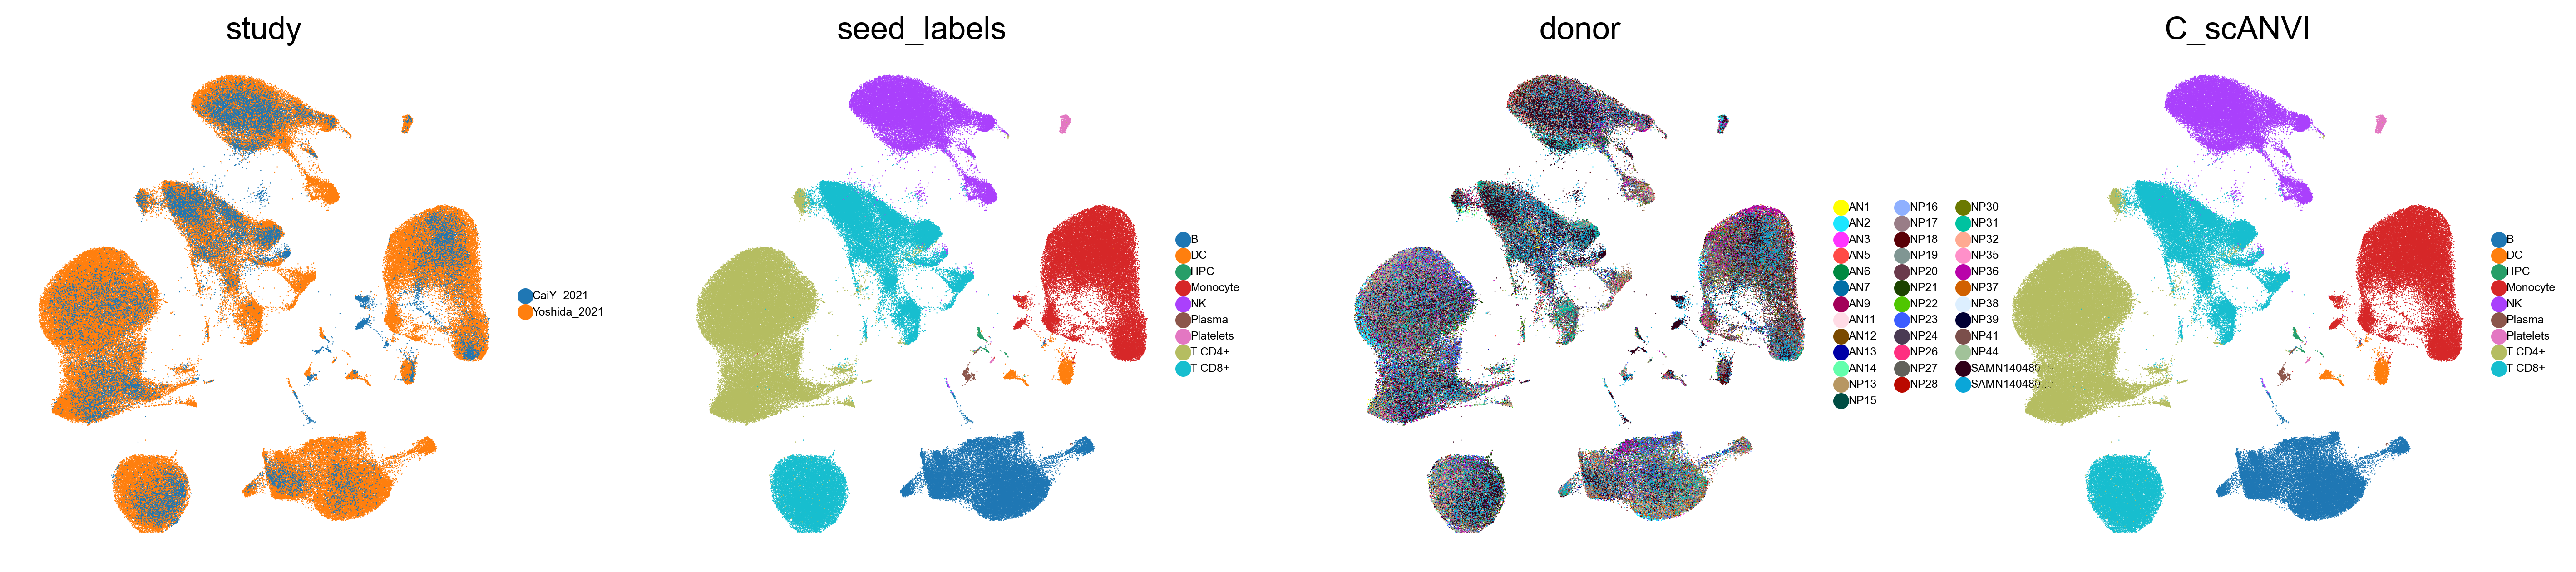

In [37]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['study', 'seed_labels', 'donor', 'C_scANVI'], size = 1, legend_fontsize = 5, ncols = 4)

In [ ]:
# sc.pl.umap(adata, frameon = False, color = ['SMK', 'n_genes', 'doublet_scores', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'sample_group', 'IAV_score'], size = 1, legend_fontsize = 5, ncols = 4, cmap = 'plasma')

### Compute integration metrics

In [43]:
adata

AnnData object with n_obs × n_vars = 195733 × 7000
    obs: 'status', 'annotation_detailed', 'annotation_detailed_fullNames', 'donor', 'tissue', 'seed_labels', 'study', 'dataset', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_id-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'name-reference', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'study_colors', 'seed_labels_colors', 'donor_colors', 'C_scANVI_colors', 'pca'
    obsm: '_scvi_extra_categorical_covs', 'X_scANVI', 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [49]:
bm = Benchmarker(
    adata,
    batch_key = 'donor',
    label_key = "C_scANVI",
    embedding_obsm_keys = ["X_pca", "X_scANVI"],
    n_jobs = -1,
)
bm.benchmark()

computing PCA
    with n_comps=50
    finished (0:00:17)


Embeddings: 100%|██████████| 2/2 [1:24:42<00:00, 2541.43s/it]


In [ ]:
bm.plot_results_table(min_max_scale = False)

### Export annotated sample object 

In [ ]:
adata.obs.index = pd.Index(['-'.join(idx.split('-')[:3]) for idx in adata.obs.index])
adata.obs.index

In [ ]:
adata_raw.obs.index = pd.Index(['-'.join(idx.split('-')[:3]) for idx in adata_raw.obs.index])
adata_raw.obs.index

In [ ]:
adata.obs_names

In [ ]:
adata.obs['C_scANVI'].cat.categories

In [ ]:
adata.obs['C_scANVI'].value_counts()

### Export annotated object with raw counts

In [ ]:
adata

In [ ]:
adata_raw

In [ ]:
adata_export = anndata.AnnData(X = adata_raw.X, obs = adata.obs, var = adata_raw.var)
# adata_export.obsm['X_scVI'] = adata.obsm['X_scVI'].copy()
adata_export.obsm['X_umap'] = adata.obsm['X_umap'].copy()
adata_export.obsm['X_scANVI'] = adata.obsm['X_scANVI'].copy()
adata_export

In [ ]:
adata_export.write('../data/Marburg_All_ctl230330_scANVI_annot.raw.h5ad')

'/data/230512_scRNA_PBMC_human_healthy_scANVI_annot.raw.h5ad'